In [1]:
name = 'poisson128'
seed = 42
path = '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/'
cuda_num = '2'

folder = 'examples'

In [2]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_num
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append(path)

In [3]:
import logging
import getpass
from time import perf_counter

import optax
from jax import random, vmap, numpy as jnp

import matplotlib.pyplot as plt

from data.dataset import load_dataset
from data.graph_utils import spmatrix_to_graph
from config import default_precorrector_config
from scipy_linsolve import make_Chol_prec_from_bcoo, batched_cg_scipy
from train import construction_time_with_gnn, train_inference_finetune, make_PreCorrector

In [4]:
key = random.PRNGKey(seed)

2025-01-15 09:58:22.988339: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
config = {
    'model_path': os.path.join(path, folder, name+'.eqx'), 
    'model_use': 'train',
    'save_model': True,
    'cg_maxiter': 250,
    'cg_atol': 1e-12
}

data_config = {
    'data_dir': path,
    'pde': 'poisson',
    'grid': 128,
    'variance': '-',
    'lhs_type': 'l_ict',
    'N_samples_train': 1000,
    'N_samples_test': 200,
    'precision': 'f64',
    'fill_factor': 1,
    'threshold': 1e-4
}

model_config = default_precorrector_config

train_config = {
    'loss_type': 'low_freq_loss',
    'model_type': 'precorrector',
    'batch_size': 8,
    'optimizer': optax.adam,
    'lr': 1e-3,
    'optim_params': {},
    'epoch_num': 500
}

In [6]:
log_filename = os.path.join(path, folder, name+'.log')

logging.basicConfig(
    level = logging.INFO,
    format = '[%(levelname)s | ' + getpass.getuser() + ' | %(asctime)s] - %(message)s',
    force = True,
    datefmt = "%Y-%m-%d %H:%M:%S",
    handlers = [logging.FileHandler(log_filename, "a", "utf-8"),
                logging.StreamHandler()]
)
logging.captureWarnings(True)
logging.info('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
logging.info(f'Script with model "{name}" started execution.')

[INFO | root | 2025-01-15 09:58:23] - %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[INFO | root | 2025-01-15 09:58:23] - Script with model "poisson128" started execution.


In [7]:
logging.info(f'Input arguments: name = {name}, seed = {seed}, cuda_num = {cuda_num}.\n')
try:
    assert os.path.isdir(path) and os.path.isdir(os.path.join(path, folder)) and os.path.isdir(data_config['data_dir']), 'Check directories'
except Exception as e:
    logging.critical(e)
    raise

[INFO | root | 2025-01-15 09:58:23] - Input arguments: name = poisson128, seed = 42, cuda_num = 2.



In [8]:
logging.info('Configs:')
logging.info('  config: %s;', config)
logging.info('  data_config: %s;', data_config)
logging.info('  model_config: %s;', model_config)
logging.info('  train_config: %s.\n', train_config)

[INFO | root | 2025-01-15 09:58:23] - Configs:
[INFO | root | 2025-01-15 09:58:23] -   config: {'model_path': '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/examples/poisson128.eqx', 'model_use': 'train', 'save_model': True, 'cg_maxiter': 250, 'cg_atol': 1e-12};
[INFO | root | 2025-01-15 09:58:23] -   data_config: {'data_dir': '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/', 'pde': 'poisson', 'grid': 128, 'variance': '-', 'lhs_type': 'l_ict', 'N_samples_train': 1000, 'N_samples_test': 200, 'precision': 'f64', 'fill_factor': 1, 'threshold': 0.0001};
[INFO | root | 2025-01-15 09:58:23] -   model_config: {'layer_type': 'Conv1d', 'alpha': 0.0, 'edge_enc': {'features': [1, 16, 16], 'N_layers': 2}, 'edge_dec': {'features': [16, 16, 1], 'N_layers': 2}, 'mp': {'edge_upd': {'features': [18, 16, 16], 'N_layers': 2}, 'node_upd': {'features': [17, 1, 1], 'N_layers': 2}, 'mp_rounds': 5}};
[INFO | root | 2025-01-15 09:58:23] -   train_config: {'loss_type': 'low_freq_loss', 'model_type': '

In [9]:
try:
    s = perf_counter()
    train_set = load_dataset(data_config, return_train=True)
    A_train, A_pad_train, b_train, bi_edges_train, x_train, ic_time_mean_train, ic_time_std_train = train_set

    test_set = load_dataset(data_config, return_train=False)
    A_test, A_pad_test, b_test, bi_edges_test, x_test, ic_time_mean_test, ic_time_std_test = test_set

    data = (
        [A_train, A_pad_train, b_train, bi_edges_train, x_train],
        [A_test, A_pad_test, b_test, bi_edges_test, x_test]
    )
    data_time = perf_counter() - s
    logging.info(f'Data is generated in {data_time:.3e} sec.\n')
except Exception as e:
    logging.critical(f'Script failed on data generation.\n{e}\n\n\n')
    raise

[INFO | root | 2025-01-15 09:58:52] - Data is generated in 2.919e+01 sec.



In [10]:
try:
    s = perf_counter()
    model, losses, _ = train_inference_finetune(key, data, make_PreCorrector, model_config,
                                                train_config, model_path=config['model_path'],
                                                model_use=config['model_use'], save_model=config['save_model'])
    training_time = perf_counter() - s
    logging.info(f'Model is trained in {training_time:.3e} sec.')
    logging.info(f'First and last losses: train = [{losses[0][0]:.3e}, {losses[0][-1]:.3e}], test = [{losses[1][0]:.3e}, {losses[1][-1]:.3e}]\n.')
except Exception as e:
    logging.critical(f'Script failed on model training.\n{e}\n\n\n')
    raise

2025-01-15 09:59:00.902677: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng21{k2=1,k4=0,k5=1,k6=0,k7=0} for conv (f32[16,16,1]{2,1,0}, u8[0]{0}) custom-call(f32[8,16,65025]{2,1,0}, f32[8,16,65025]{2,1,0}), window={size=1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-01-15 09:59:00.985179: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.082644017s
Trying algorithm eng21{k2=1,k4=0,k5=1,k6=0,k7=0} for conv (f32[16,16,1]{2,1,0}, u8[0]{0}) custom-call(f32[8,16,65025]{2,1,0}, f32[8,16,65025]{2,1,0}), window={size=1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

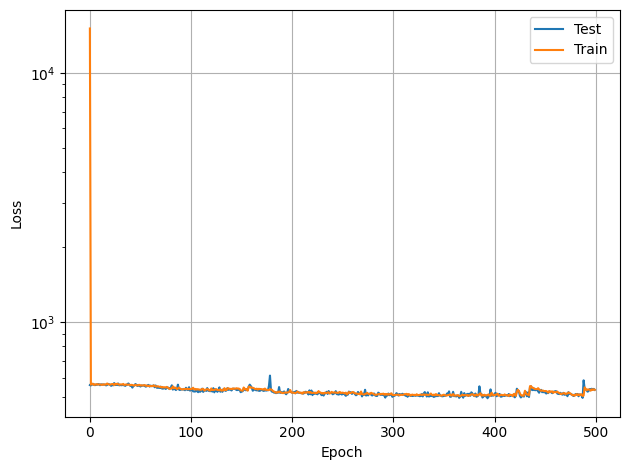

In [11]:
plt.plot(range(len(losses[0])), losses[1], label='Test')
plt.plot(range(len(losses[0])), losses[0], label='Train')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout();

In [12]:
try:
    time_gnn_mean, time_gnn_std = construction_time_with_gnn(model, A_test[0, ...], A_pad_test[0, ...], b_test[0, ...],
                                                             bi_edges_test[0, ...], num_rounds=A_test.shape[0],
                                                             pre_time_ic=ic_time_mean_test)
    L = vmap(model, in_axes=(0), out_axes=(0))(spmatrix_to_graph(A_pad_test, b_test))
    P = make_Chol_prec_from_bcoo(L)
    P_ic0 = make_Chol_prec_from_bcoo(A_pad_test)
    
    logging.info(f'Precs are combined:')
    logging.info(f' classical prec construction time (sec) : mean = {ic_time_mean_test:.3e}, std = {ic_time_std_test:.3e};')
    logging.info(f' GNN prec construction time (sec) : mean = {time_gnn_mean:.3e}, std = {time_gnn_std:.3e}.\n')
except Exception as e:
    logging.critical(f'Script failed on precs combination.\n{e}\n\n\n')
    raise

[INFO | root | 2025-01-15 10:22:59] - Precs are combined:
[INFO | root | 2025-01-15 10:22:59] -  classical prec construction time (sec) : mean = 3.087e-03, std = 4.437e-05;
[INFO | root | 2025-01-15 10:22:59] -  GNN prec construction time (sec) : mean = 3.625e-03, std = 1.500e-04.



In [13]:
try:
    iters_stats, time_stats, nan_flag = batched_cg_scipy(A_test, b_test, time_gnn_mean, 'random',
                                                         key, P, config['cg_atol'],
                                                         config['cg_maxiter'], thresholds=[1e-3, 1e-6, 1e-9, 1e-12])
    logging.info('CG with GNN is finished:')
    logging.info(f' iterations to atol([mean, std]): %s;', iters_stats)
    logging.info(f' time to atol([mean, std]): %s;', time_stats)
    logging.info(f' number of linsystems for which CG did not conerge to atol: %s.\n', time_stats)
except Exception as e:
    logging.critical(f'Script failed on CG with GNN.\n{e}\n\n\n')
    raise

[INFO | root | 2025-01-15 10:25:00] - CG with GNN is finished:
[INFO | root | 2025-01-15 10:25:00] -  iterations to atol([mean, std]): {0.001: [35.0, 0.0], 1e-06: [45.8, 0.41], 1e-09: [55.6, 0.49], 1e-12: [64.0, 0.0]};
[INFO | root | 2025-01-15 10:25:00] -  time to atol([mean, std]): {0.001: [0.3266, 0.01626], 1e-06: [0.4254, 0.02058], 1e-09: [0.5164, 0.0279], 1e-12: [0.5931, 0.03129]};
[INFO | root | 2025-01-15 10:25:00] -  number of linsystems for which CG did not conerge to atol: {0.001: [0.3266, 0.01626], 1e-06: [0.4254, 0.02058], 1e-09: [0.5164, 0.0279], 1e-12: [0.5931, 0.03129]}.



In [14]:
try:
    iters_stats_ic0, time_stats_ic0, nan_flag_ic0 = batched_cg_scipy(A_test, b_test, ic_time_mean_test, 'random',
                                                                     key, P_ic0, config['cg_atol'],
                                                                     config['cg_maxiter'], thresholds=[1e-3, 1e-6, 1e-9, 1e-12])
    logging.info('CG with classical prec is finished:')
    logging.info(f' iterations to atol([mean, std]): %s;', iters_stats_ic0)
    logging.info(f' time to atol([mean, std]): %s;', time_stats_ic0)
    logging.info(f' number of linsystems for which CG did not conerge to atol: %s.\n', nan_flag_ic0)
except Exception as e:
    logging.critical(f'Script failed on CG with classical prec.\n{e}\n\n\n')
    raise

[INFO | root | 2025-01-15 10:29:05] - CG with classical prec is finished:
[INFO | root | 2025-01-15 10:29:05] -  iterations to atol([mean, std]): {0.001: [35.0, 0.0], 1e-06: [45.8, 0.41], 1e-09: [55.6, 0.49], 1e-12: [64.0, 0.0]};
[INFO | root | 2025-01-15 10:29:05] -  time to atol([mean, std]): {0.001: [0.3266, 0.01626], 1e-06: [0.4254, 0.02058], 1e-09: [0.5164, 0.0279], 1e-12: [0.5931, 0.03129]};
[INFO | root | 2025-01-15 10:29:05] -  number of linsystems for which CG did not conerge to atol: {0.001: [0.3266, 0.01626], 1e-06: [0.4254, 0.02058], 1e-09: [0.5164, 0.0279], 1e-12: [0.5931, 0.03129]}.



In [15]:
logging.info(f'Script with model "{name}" finished execution.\n\n\n')

[INFO | root | 2025-01-15 10:29:05] - Script with model "poisson128" finished execution.



